## Second Assignment of the Applied Machine Learning Course
### By: Artopoulos Georgios t8200016

After downloading and  getting familiar with the data from the [NAVCO 1.2 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0UZOTX) and the [Polity5 Annual Time-Series, 1946-2018](http://www.systemicpeace.org/inscr/p5v2018.xls) datasets, we will try to answer the following :

1. Exploration of Historical Trends
2. Largest Resistance Campaigns, 1946-2014
3. The Effect of Participation on the Probability of Campaign Success
4. The Level of Participation Tipping Point
5. Nonviolent Resistance and Target Regime Type

Clear outputs and reset Kernel before running all cells.

### Importing the necessary libraries to complete the above tasks:

`pandas` will be used throughout the assigment to load the necessary data and create dataframes as well as for data manipulation and analysis

`numpy` will be used for the creation of arrays, replacing values in the dataframes and statistics

`matplotlib` will be used for the creation of different kinds of plots and graphs such as stacked line plots and bar charts

`seaborn` will be used for the creation of scatter plots and bar plots

`statsmodels` will be used for the creation of the logistic regression model and the calculation of the VIF

`xlrd` will be used to read the excels files

`prettytable` will be used to create pretty visualizations of dataframes


***Please make sure you have installed all the necessary libraries before running the code.***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from prettytable import PrettyTable

# 2. Importing the necessary data from the .tab and .xls files

Using the `pd.read_csv()` function we can read the .tab file and create a dataframe. The `sep='\t'` argument is used to specify that the file is tab delimited. Also, we will remove the excess rows that contain null values and keep only the first 388 rows, using the `loc` function. Finally, we will use the `pd.read_excel()` function to read the .xls file and create a dataframe.

In [2]:
#reading the tab file
navco = pd.read_csv('data/NAVCO 1.2 Updated.tab', sep='\t')

#remove null values and keep only the first 388 rows
navco = navco.loc[:388]

#make the EYEAR column an integer
navco['EYEAR'] = navco['EYEAR'].astype(int)

#read the xls file
polity5 = pd.read_excel('data/p5v2018.xls')

#make the year column an integer
polity5['year'] = polity5['year'].astype(int)

## Task 1:  Exploration of Historical Trends

For this task we need to create three plots. The first one will be a stacked line plot that will show the frequency on nonviolent and violent campaigns over time. The second one will be a bar chart that will show the number of nonviolent campaigns and they success rate for each decade. The third one will be a bar chart with the success rate of nonviolent campaigns and violent campaigns for each decade.


### 1.1 Stacked Line Plot

A stacked line plot, often referred to as a stacked area chart or stacked line graph, is a type of data visualization that displays the cumulative contribution of multiple variables over a common axis. In this type of plot, multiple lines (or areas) are stacked on top of each other, and the vertical position of a point on the stack represents the combined value of the variables up to that point. 

In our case, the vertical position of a point on the stack represents the combined frequency of the nonviolent and violent campaigns per decade.

To create it we will do the following:

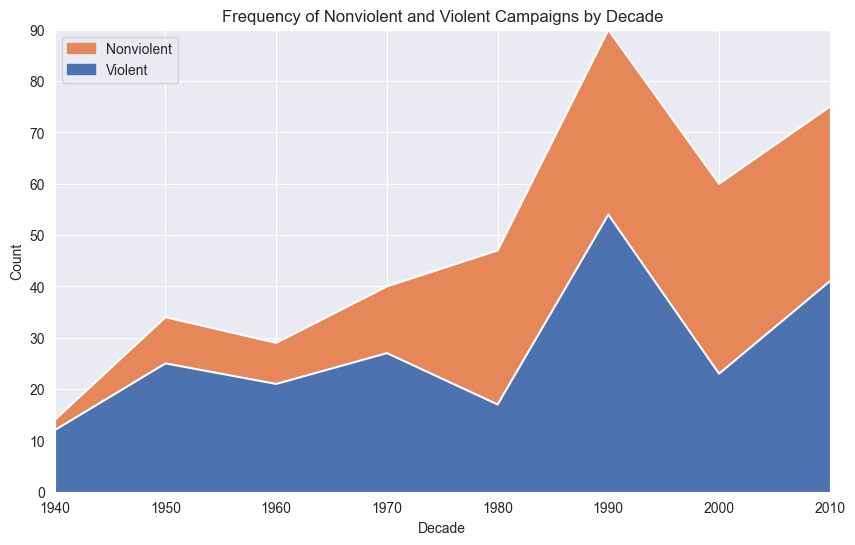

In [3]:
# Selecting columns the necessary columns from the 'navco' DataFrame and creating a new DataFrame 'stacked_chart_data'
stacked_chart_data = navco[['EYEAR', 'NONVIOL', 'VIOL']]

# Make a copy of the DataFrame to avoid modifying the original data
stacked_chart_data = stacked_chart_data.copy()

# Creating a new column 'Decade' that contains the decade of each campaign using DIV to divide the year by 10 and then multiply by 10
stacked_chart_data['Decade'] = ((stacked_chart_data['EYEAR'] // 10) * 10)

# Grouping the data by decade, campaign type (nonviolent and violent), and counting the number of campaigns in each group
# Naming the resulting count column as 'count'
grouped = stacked_chart_data.groupby(['Decade', 'NONVIOL', 'VIOL']).size().reset_index(name='count')

# Creating a DataFrame for nonviolent campaigns and removing the 'VIOL' column
grouped_NV = grouped[grouped['NONVIOL'] == 1].drop(['VIOL'], axis=1)

# Creating a DataFrame for violent campaigns and removing the 'NONVIOL' column
grouped_V = grouped[grouped['VIOL'] == 1].drop(['NONVIOL'], axis=1)

# Adding the 'count' column from the nonviolent DataFrame to the violent DataFrame
total_counts = grouped_NV['count'].values + grouped_V['count'].values

# Creating a plot to visualize the frequency of nonviolent and violent campaigns by decade
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the count of violent campaigns over decades
ax.plot(grouped_V['Decade'], grouped_V['count'], color='white')

# Plotting the sum of counts of nonviolent and violent campaigns over decades
ax.plot(grouped_NV['Decade'], total_counts, color='white')

# Setting the labels and title for the plot
ax.set_xlabel('Decade')
ax.set_ylabel('Count')
ax.set_title('Frequency of Nonviolent and Violent Campaigns by Decade')

# Filling the area between the two lines with colors representing nonviolent and violent campaigns
ax.fill_between(grouped_NV['Decade'], grouped_V['count'], total_counts, color='#e58759', label='Nonviolent')
ax.fill_between(grouped_NV['Decade'], grouped_V['count'], color='#4c72b0', label='Violent')

# Adding a legend to the plot
plt.legend(loc='upper left')

# Setting the plot limits and adding grid lines
plt.xlim(1940, 2010)
plt.ylim(0, 90)
plt.grid(True)

# Making sure the grid is behind the plot
ax.set_axisbelow(True)

# Displaying the plot
plt.show()

### 1.2 Bar Charts

For this task, the suitable chart is a clustered bar chart. In this type of chart, bars of varying colors are grouped together, facilitating a straightforward comparison of values among the different bars. The clustering arrangement enhances the ease of comparing these values.

In our case, we will create two clustered bar charts. The first one will show the number of nonviolent campaigns and their success rate for each decade. The second one will show the success rate of nonviolent campaigns and violent campaigns for each decade.

To create the first bar chart we will to find the number of nonviolent campaigns and their success rate for each decade. 

For the number of nonviolent campaigns we will do the following:

In [4]:
# Selecting columns the necessary columns from the 'navco' DataFrame and creating a new DataFrame 'bar_chart_data'
bar_chart_data = navco[['EYEAR', 'NONVIOL', 'VIOL', 'SUCCESS', 'FAILURE']]

# Creating a copy of the DataFrame to avoid modifying the original data
bar_chart_data = bar_chart_data.copy()

# Creating a new column 'DECADE' that contains the decade of each campaign using DIV to divide the year by 10 and then multiply by 10
bar_chart_data['DECADE'] = ((bar_chart_data['EYEAR'] // 10) * 10)

# Grouping the data by decade and campaign type (nonviolent) and counting the number of campaigns in each group
# Naming the resulting count column as 'count'
group_NV = bar_chart_data.groupby(['DECADE', 'NONVIOL']).size().reset_index(name='count')

# Creating a DataFrame for nonviolent campaigns and keeping only the 'DECADE' and 'count' columns
count_NV = group_NV[group_NV['NONVIOL'] == 1]

# Printing the 'DECADE' and 'count' columns for nonviolent campaigns
count_NV[['DECADE', 'count']]

,DECADE,count
1,1940,2
3,1950,9
5,1960,8
7,1970,13
9,1980,30
11,1990,36
13,2000,37
15,2010,34


For the success rate of nonviolent campaigns we will do the following:

In [5]:
# Grouping the data by decade, success status, and campaign type (nonviolent)
# Counting the number of campaigns in each group and naming the resulting count column as 'count'
NVpercentage = bar_chart_data.groupby(['DECADE', 'SUCCESS', 'NONVIOL']).size().reset_index(name='count')

# Keeping only the rows where 'NONVIOL' is 1 (indicating nonviolent campaigns)
NVpercentage = NVpercentage[NVpercentage['NONVIOL'] == 1]

# Creating a new column 'summary' that holds the sum of counts for each decade
NVpercentage['summary'] = NVpercentage.groupby('DECADE')['count'].transform('sum')

# Calculating the percentage of nonviolent campaigns with respect to the total campaigns in each decade
NVpercentage['percentage'] = NVpercentage['count'] / NVpercentage['summary']

# Keeping only the rows where 'SUCCESS' is 1 (indicating successful campaigns)
NVpercentage = NVpercentage[NVpercentage['SUCCESS'] == 1]

# Rounding the 'percentage' column to two decimal places for clarity
NVpercentage['percentage'] = NVpercentage['percentage'].round(2)

# Printing the 'DECADE' and 'percentage' columns for successful nonviolent campaigns
NVpercentage[['DECADE', 'percentage']]

,DECADE,percentage
3,1940,0.50
7,1950,0.22
11,1960,0.25
15,1970,0.54
19,1980,0.47
23,1990,0.83
27,2000,0.68
31,2010,0.38


And then create the bar chart:

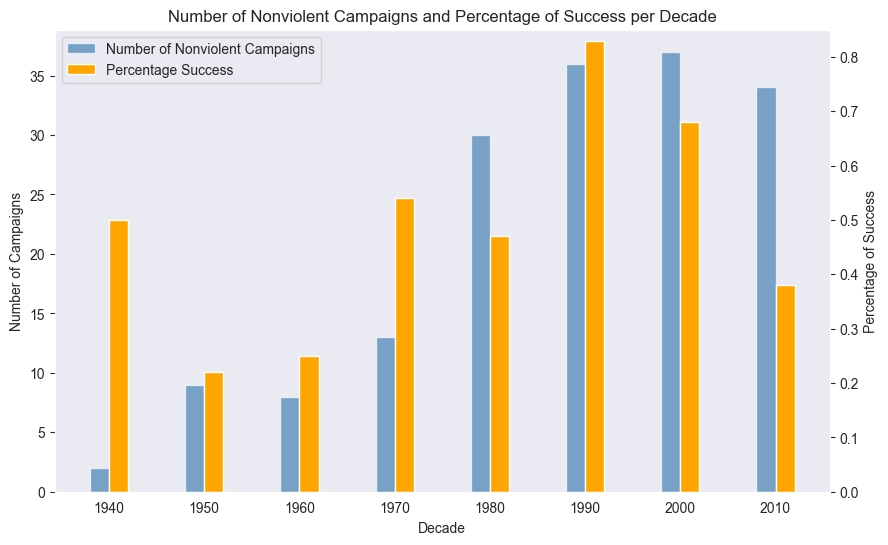

In [6]:
# Creating a new figure and two axes for a dual-axis bar plot
fig2, ax1 = plt.subplots()

# Adjusting the size of the plot
fig2.set_size_inches(10, 6)

# Bar plot for the count of nonviolent campaigns
ax1.bar(count_NV['DECADE'] - 1, count_NV['count'], color='#4682b4', width=2, label='Count', alpha=0.7, align='center')

# Creating a twin axis for the percentage data
ax2 = ax1.twinx()

# Bar plot for the percentage of success for nonviolent campaigns
ax2.bar(NVpercentage['DECADE'] + 1, NVpercentage['percentage'], color='orange', width=2, label='Percentage')

# Setting labels and title for the plot
ax1.set_xlabel('Decade')
ax1.set_ylabel('Number of Campaigns')
ax2.set_ylabel('Percentage of Success')
plt.title('Number of Nonviolent Campaigns and Percentage of Success per Decade')

# Combining legends from both axes into one legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=['Number of Nonviolent Campaigns', 'Percentage Success'], loc='upper left')

# Adjusting the left y-axis limit for the percentage axis
ax2.set_ylim(0, 0.85)

# Removing grid lines from both axes
ax1.grid(False)
ax2.grid(False)

# Displaying the plot
plt.show()

To create the second bar chart we will need the success rate of nonviolent campaigns and violent campaigns for each decade.
We already have the success rate of nonviolent campaigns for each decade, so we will find it for violent campaigns:

In [7]:
# Grouping the data by decade, success status, and campaign type (violent)
# Counting the number of campaigns in each group and naming the resulting count column as 'count'
Vpercentage = bar_chart_data.groupby(['DECADE', 'SUCCESS', 'VIOL']).size().reset_index(name='count')

# Keeping only the rows where 'VIOL' is 1 (indicating violent campaigns)
Vpercentage = Vpercentage[Vpercentage['VIOL'] == 1]

# Creating a new column 'summary' that holds the sum of counts for each decade
Vpercentage['summary'] = Vpercentage.groupby('DECADE')['count'].transform('sum')

# Keeping only the rows where 'SUCCESS' is 1 (indicating successful campaigns)
Vpercentage = Vpercentage[Vpercentage['SUCCESS'] == 1]

# Calculating the percentage of violent campaigns with respect to the total campaigns in each decade
Vpercentage['percentage'] = Vpercentage['count'] / Vpercentage['summary']

# Rounding the 'percentage' column to two decimal places for clarity
Vpercentage['percentage'] = Vpercentage['percentage'].round(2)

# Displaying the 'DECADE' and 'percentage' columns for successful violent campaigns
Vpercentage[['DECADE', 'percentage']]

,DECADE,percentage
3,1940,0.50
7,1950,0.32
11,1960,0.19
15,1970,0.44
19,1980,0.29
23,1990,0.28
27,2000,0.13
31,2010,0.07


And then create we the bar chart:

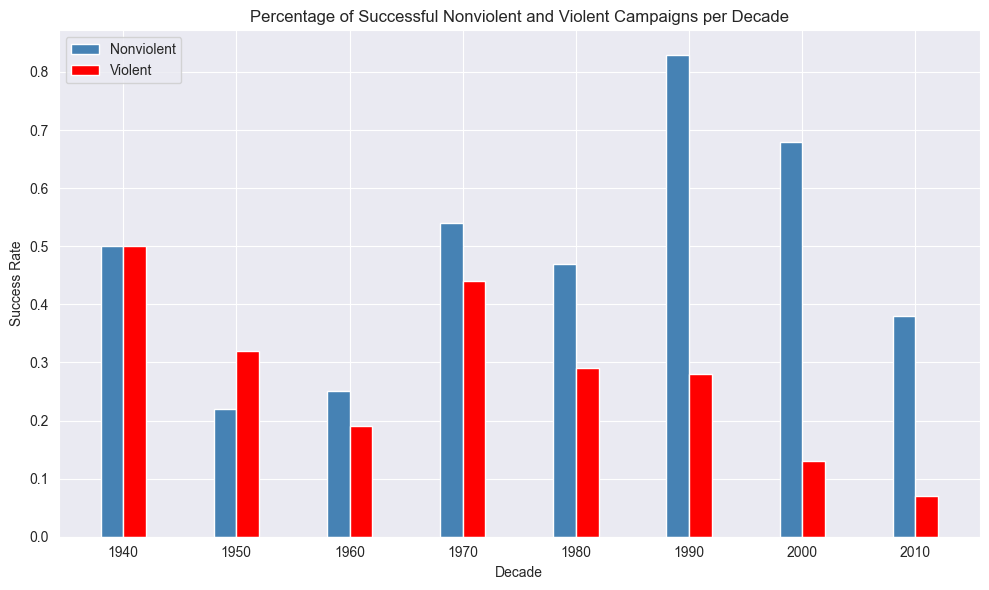

In [8]:
# Plotting a bar chart for the percentage of successful nonviolent and violent campaigns
fig3, ax1 = plt.subplots()

# Adjusting the size of the plot
fig3.set_size_inches(10, 6)

# Bar plot for the percentage of successful nonviolent campaigns
ax1.bar(count_NV['DECADE'] - 1, NVpercentage['percentage'], color='#4682b4', width=2, label='Nonviolent')

# Bar plot for the percentage of successful violent campaigns
ax1.bar(Vpercentage['DECADE'] + 1, Vpercentage['percentage'], color='red', width=2, label='Violent')

# Setting labels and title for the plot
ax1.set_xlabel('Decade')
ax1.set_ylabel('Success Rate')
plt.title('Percentage of Successful Nonviolent and Violent Campaigns per Decade')

# Combining legends for both bars into one legend
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(handles=handles1, labels=['Nonviolent', 'Violent'], loc='upper left')

# Ensuring tight layout for better visualization
fig3.tight_layout()

# Displaying the plot
plt.show()

## Task 2: Largest Resistance Campaigns, 1946-2014

For this task we need to a horizontal bar plot with the resistance campaigns, for all years, with a percentage of participation at least 2.0%

To create it, we will need to find the resistance campaigns for all years with a percentage of participation at least 2.0%:

In [9]:
# Selecting columns the necessary columns from the 'navco' DataFrame and creating a new DataFrame 'hor_barchart_data'
hor_barchart_data = navco[['TARGET', 'LOCATION', 'PERCENTAGEPOPULARPARTICIPATION','SUCCESS', 'FAILURE', 'LIMITED']]

# Filtering the data to keep only the campaigns with a percentage of participation at least 2.0%
hor_barchart_data = hor_barchart_data[(hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION'] * 100 >= 2.0)]

# # Filtering the data to keep only the campaigns with a percentage of participation at least 2.0% and with Greece


# Creating a new column that combines the 'TARGET' and 'LOCATION' information
hor_barchart_data['Target_Location'] = hor_barchart_data['LOCATION'] + ': ' + hor_barchart_data['TARGET']

# Sorting the data by the percentage of popular participation in descending order
hor_barchart_data = hor_barchart_data.sort_values(by='PERCENTAGEPOPULARPARTICIPATION', ascending=False)

#print the Target_Location and PERCENTAGEPOPULARPARTICIPATION columns
hor_barchart_data[['Target_Location', 'PERCENTAGEPOPULARPARTICIPATION']]

,Target_Location,PERCENTAGEPOPULARPARTICIPATION
295,Slovenia: Yugoslavian rule,0.450129
14,Argentina: military junta,0.302013
384,Zambia: British rule,0.285063
192,Lebanon: Syrian forces,0.250824
194,Lebanon: Government of Prime Minister Fouad Si...,0.194598
104,Estonia: Communist regime,0.192146
342,Tunisia: Council negotiating end to political ...,0.179470
98,Egypt: President Morsi,0.155889
187,Latvia: Communist regime,0.094319
4,Albania: Communist regime,0.091068


And then create the horizontal bar plot:

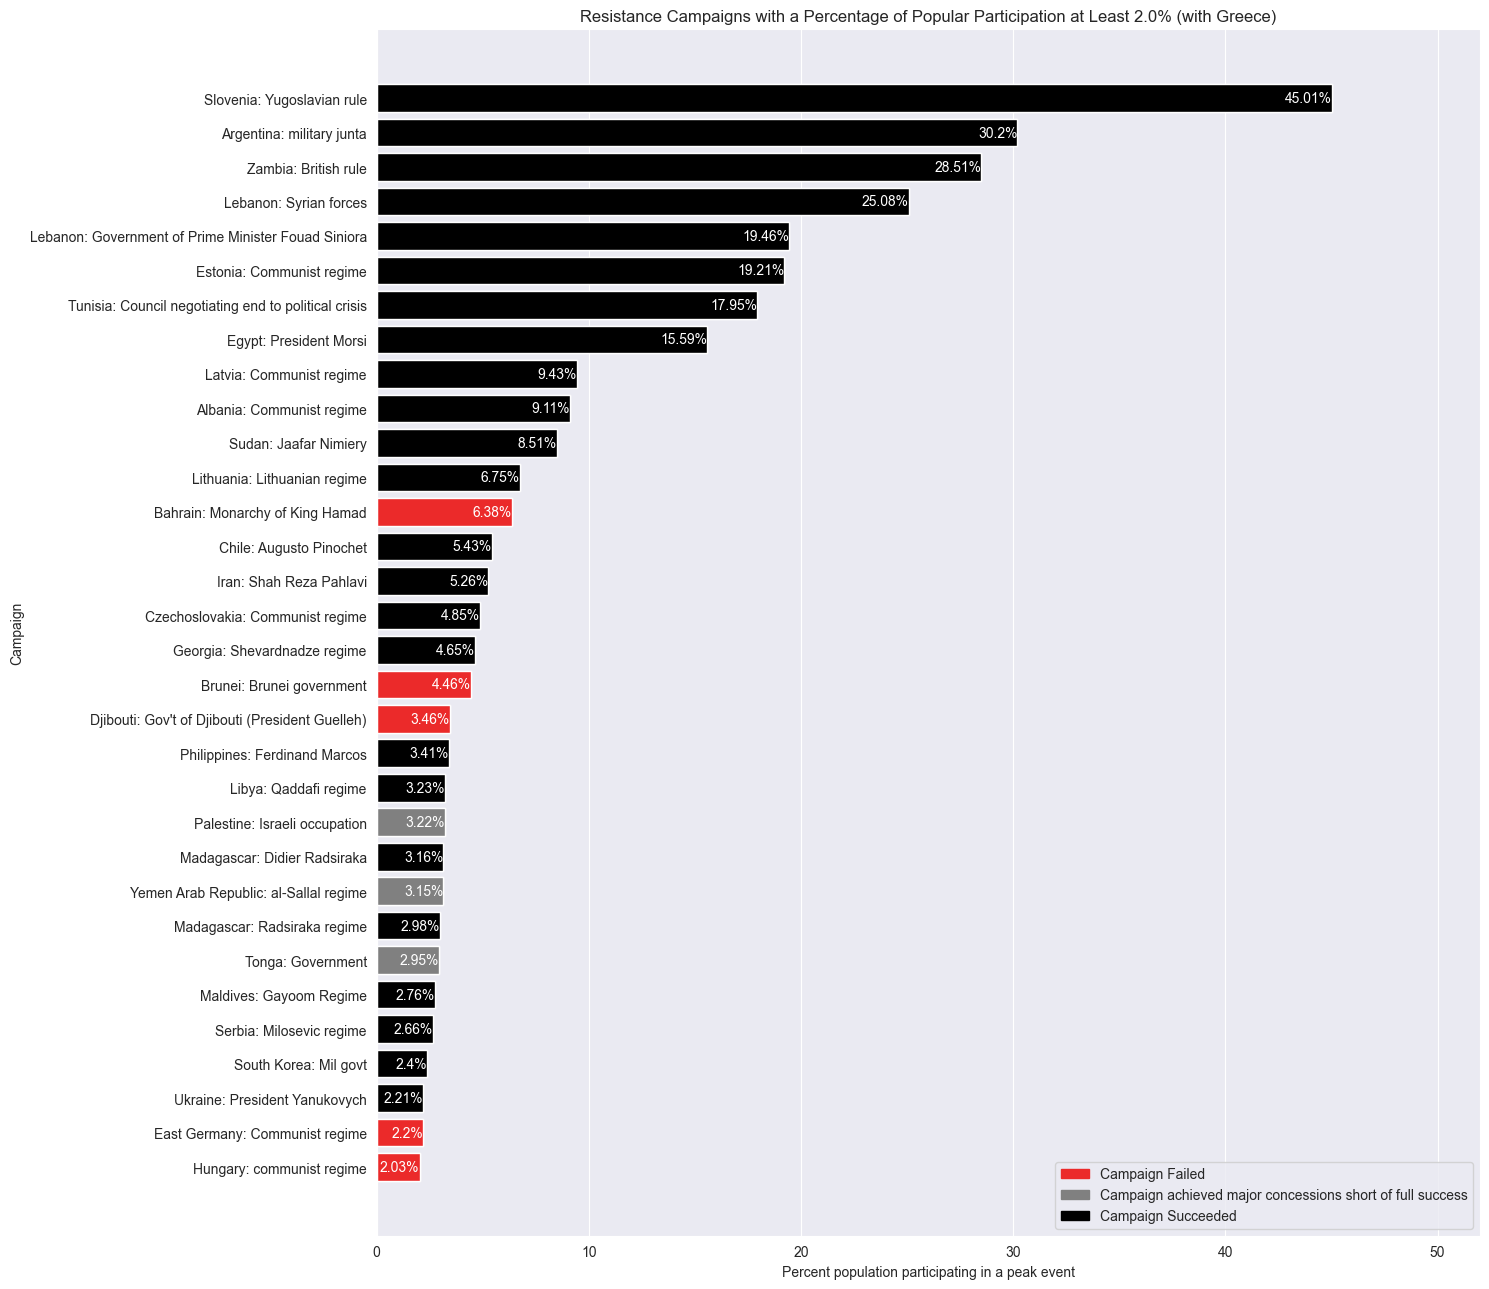

In [10]:
# Create a side bar plot with rank as the x-axis and the percentage of popular participation as the y-axis
plt.figure(figsize=(15, 13))

# Convert the percentage of popular participation to percentages
hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION'] = (hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION'] * 100)

# Using seaborn to create a bar plot with 'PERCENTAGEPOPULARPARTICIPATION' on the x-axis and 'Target_Location' on the y-axis
sns.barplot(x='PERCENTAGEPOPULARPARTICIPATION', y='Target_Location', data=hor_barchart_data)

# Add the percentage of popular participation to the bars
for index, value in enumerate(hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION']):
    # If it is Greece, add the percentage of popular participation to the end of the bar
    percent = round(value, 2)
    plt.text(value, index, str(percent) + '%', va='center', ha='right', color='white')

    # Check if the campaign is successful, a failure, or a limited success, and color the bar accordingly
    if hor_barchart_data['SUCCESS'].iloc[index] == 1:
        plt.barh(index, value, color='black')
    elif hor_barchart_data['FAILURE'].iloc[index] == 1:
        plt.barh(index, value, color='#eb2a2a')
    elif hor_barchart_data['LIMITED'].iloc[index] == 1:
        plt.barh(index, value, color='#808080')

# Set plot title, x-axis label, and y-axis label
plt.title('Resistance Campaigns with a Percentage of Popular Participation at Least 2.0% (with Greece)')
plt.xlabel('Percent population participating in a peak event')
plt.ylabel('Campaign')

# Ensure enough space for labels
plt.tight_layout()

# Change the x-axis limits
plt.xlim(0, 52)

# Create labels for the legend
success = mpatches.Patch(color='black', label='Campaign Succeeded')
failure = mpatches.Patch(color='#eb2a2a', label='Campaign Failed')
limited = mpatches.Patch(color='#808080', label='Campaign achieved major concessions short of full success')

# Add labels to the legend
plt.legend(handles=[failure, limited, success], loc='lower right')

# Make the grid be behind the bars
plt.gca().set_axisbelow(True)

# Show the plot
plt.show()

Let's see if we can find anything interesting about greece in the NAVCO dataset:

In [11]:
#filtering the navco dataset to keep only the greek campaigns
greek_campaigns = navco[navco['LOCATION'] == 'Greece']

#printing the greek campaigns
greek_campaigns

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,...,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
119,401.0,Greek Civil War,Greece,1946.0,1949,British and US occupation,0.0,0.0,1.0,0.0,...,0.0,1778.0,40000.0,0.005092,1.0,0.0,NaN,0.0,1.0,1.0
120,89.0,Greek anti-military,Greece,1973.0,1974,Military rule,1.0,0.0,0.0,0.0,...,0.0,654.0,2500.0,0.000279,1.0,1.0,1.0,0.0,1.0,0.0


Lets check how greek campaigns compare to the campaigns that have a percentage of popular participation at least 2.0% (we repeat everything that we did above but this time we filter the data to keep the greek campaigns):

In [12]:
# Selecting columns the necessary columns from the 'navco' DataFrame and creating a new DataFrame 'hor_barchart_data'
hor_barchart_data = navco[['TARGET', 'LOCATION', 'PERCENTAGEPOPULARPARTICIPATION','SUCCESS', 'FAILURE', 'LIMITED']]

# Filtering the data to keep only the campaigns with a percentage of participation at least 2.0%
hor_barchart_data = hor_barchart_data[(hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION'] * 100 >= 2.0) | (hor_barchart_data['LOCATION'] == 'Greece')]

# # Filtering the data to keep only the campaigns with a percentage of participation at least 2.0% and with Greece


# Creating a new column that combines the 'TARGET' and 'LOCATION' information
hor_barchart_data['Target_Location'] = hor_barchart_data['LOCATION'] + ': ' + hor_barchart_data['TARGET']

# Sorting the data by the percentage of popular participation in descending order
hor_barchart_data = hor_barchart_data.sort_values(by='PERCENTAGEPOPULARPARTICIPATION', ascending=False)

#print the Target_Location and PERCENTAGEPOPULARPARTICIPATION columns
hor_barchart_data[['Target_Location', 'PERCENTAGEPOPULARPARTICIPATION']]

,Target_Location,PERCENTAGEPOPULARPARTICIPATION
295,Slovenia: Yugoslavian rule,0.450129
14,Argentina: military junta,0.302013
384,Zambia: British rule,0.285063
192,Lebanon: Syrian forces,0.250824
194,Lebanon: Government of Prime Minister Fouad Si...,0.194598
104,Estonia: Communist regime,0.192146
342,Tunisia: Council negotiating end to political ...,0.179470
98,Egypt: President Morsi,0.155889
187,Latvia: Communist regime,0.094319
4,Albania: Communist regime,0.091068


And then create the horizontal bar plot with the addition of the greek campaigns:

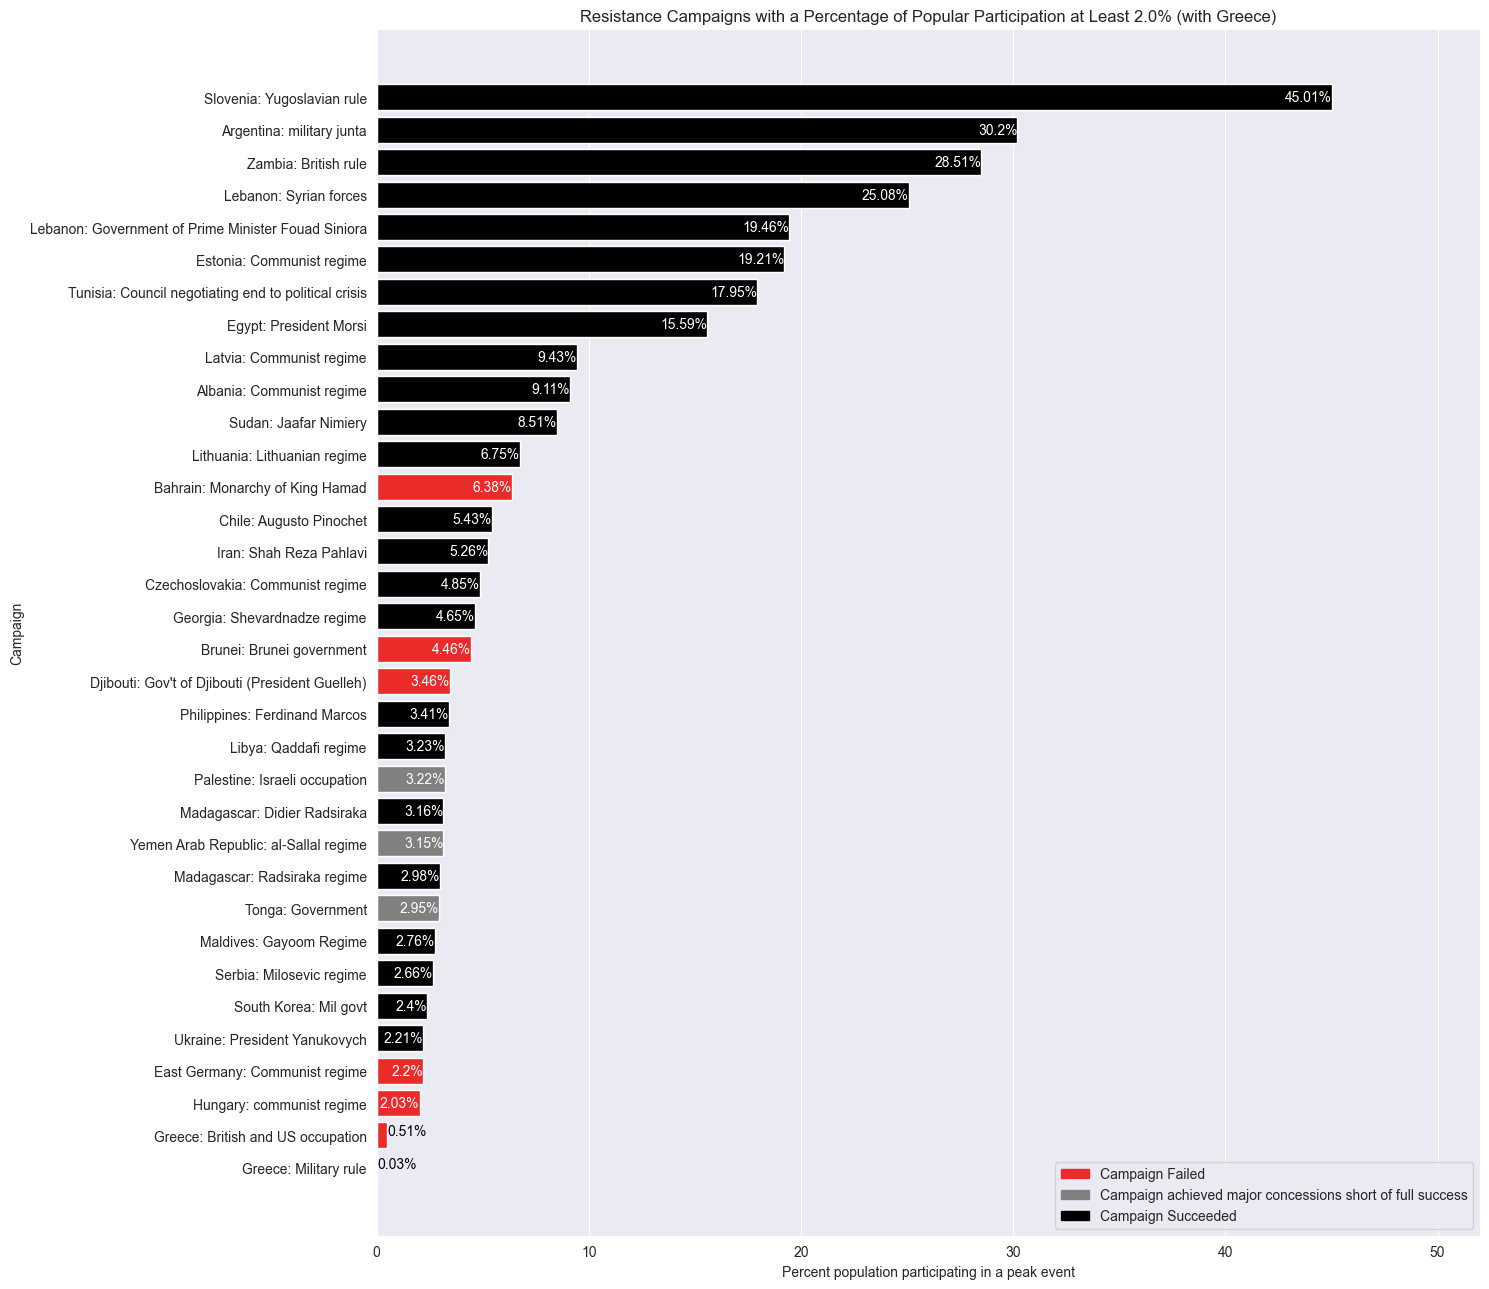

In [13]:
# Create a side bar plot with rank as the x-axis and the percentage of popular participation as the y-axis
plt.figure(figsize=(15, 13))

# Convert the percentage of popular participation to percentages
hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION'] = (hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION'] * 100)

# Using seaborn to create a bar plot with 'PERCENTAGEPOPULARPARTICIPATION' on the x-axis and 'Target_Location' on the y-axis
sns.barplot(x='PERCENTAGEPOPULARPARTICIPATION', y='Target_Location', data=hor_barchart_data)

# Add the percentage of popular participation to the bars
for index, value in enumerate(hor_barchart_data['PERCENTAGEPOPULARPARTICIPATION']):
    # If it is Greece, add the percentage of popular participation to the end of the bar
    percent = round(value, 2)
    if hor_barchart_data['LOCATION'].iloc[index] == 'Greece':
        plt.text(value, index, str(percent) + '%', color='black')
    else:
        plt.text(value, index, str(percent) + '%', va='center', ha='right', color='white')

    # Check if the campaign is successful, a failure, or a limited success, and color the bar accordingly
    if hor_barchart_data['SUCCESS'].iloc[index] == 1:
        plt.barh(index, value, color='black')
    elif hor_barchart_data['FAILURE'].iloc[index] == 1:
        plt.barh(index, value, color='#eb2a2a')
    elif hor_barchart_data['LIMITED'].iloc[index] == 1:
        plt.barh(index, value, color='#808080')

# Set plot title, x-axis label, and y-axis label
plt.title('Resistance Campaigns with a Percentage of Popular Participation at Least 2.0% (with Greece)')
plt.xlabel('Percent population participating in a peak event')
plt.ylabel('Campaign')



# Create labels for the legend
success = mpatches.Patch(color='black', label='Campaign Succeeded')
failure = mpatches.Patch(color='#eb2a2a', label='Campaign Failed')
limited = mpatches.Patch(color='#808080', label='Campaign achieved major concessions short of full success')

# Add labels to the legend
plt.legend(handles=[failure, limited, success], loc='lower right')

# Ensure enough space for labels
plt.tight_layout()

# Change the x-axis limits
plt.xlim(0, 52)

# Make the grid be behind the bars
plt.gca().set_axisbelow(True)

# Show the plot
plt.show()

We can see that the greek campaigns did not have a high percentage of popular participation which means that only a small fraction of the population participated in them.

Lets investigate further about them using the polity5 dataset:

In [14]:
#finding the campaigns that have greece as country and year  1949 and 1974
greek_campaigns_polity5 = polity5[(polity5['country'] == 'Greece') & ( (polity5['year'] == 1949) | (polity5['year'] == 1974))]

#printing the greek campaigns year and polity scores
greek_campaigns_polity5[['year', 'polity2', 'polity','democ', 'autoc']]

,year,polity2,polity,democ,autoc
6019,1949,4.0,4,7,3
6044,1974,1.0,-88,-88,-88


We can see that the polity2 score for greece was always greater than 0 which means that greece was a democracy with some autocratic traits at the peak of its campaigns. Although the polity, democ and autoc scores -88 suggest that in 1974 freece was in a perido of political transition and significant change in regime type.

Some extra historical information about those 2 campaigns:

**The Greek Civil War** (Greek: Eμφύλιος Πόλεμος, romanized: Emfýlios Pólemos): took place from 1946 to 1949. The conflict, which erupted shortly after the end of World War II, consisted of a communist-dominated uprising against the established government of the Kingdom of Greece. The opposition declared a people's republic, the Provisional Democratic Government of Greece, which was governed by the Communist Party of Greece (KKE) and its military branch, the Democratic Army of Greece (DSE). The rebels were supported by Yugoslavia and the Soviet Union while the greek government was aligned with the Truman Doctrine's Cold War containment strategy, the U.S. offered substantial military aid, equipment, and advisors, while the U.K. also played a significant role. With the support of the United Kingdom and United States, the Greek government forces ultimately prevailed. 

[Source: Wikipedia](https://en.wikipedia.org/wiki/Greek_Civil_War)



**The Greek junta or Regime of the Colonels**: was a right-wing military dictatorship that ruled Greece from 1967 to 1974. On 21 April 1967, a group of colonels overthrew the caretaker government a month before scheduled elections which Georgios Papandreou's Centre Union was favoured to win.

The dictatorship was characterised by policies such as anti-communism, restrictions on civil liberties, and the imprisonment, torture, and exile of political opponents. It was ruled by Georgios Papadopoulos from 1967 to 1973, but an attempt to renew its support in a 1973 referendum on the monarchy and gradual democratisation was ended by another coup by the hardliner Dimitrios Ioannidis, who ruled it until it fell on 24 July 1974 under the pressure of the Turkish invasion of Cyprus, leading to the Metapolitefsi ("regime change") (Greek: Μεταπολίτευση) to democracy and the establishment of the Third Hellenic Republic. It has been said to have been heavily influenced by the CIA. 

[Source: Wikipedia](https://en.wikipedia.org/wiki/Greek_junta)


## Task 3: The Effect of Participation on the Probability of Campaign Success

For this this we need to examine the effect of participation on the probability of campaign success. We will do that by running  logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends.

To do this we need to we need to first find the logged population and the logged participants per capita. From the NAVCO 1.1 codebook we can find the population with some modifications to this formula:

$$Percentage Popular Participation = \frac{participation}{population}$$

and then the participants per capita using this formula:

$$Participants Per Capita = \frac{ln(participation)}{ln(population)}$$

So we have the following:

In [15]:
# Select only the specified columns from the 'navco' DataFrame
RegData = navco[['SUCCESS', 'PARTICIPATION', 'PERCENTAGEPOPULARPARTICIPATION']]

# Create a copy of the selected columns DataFrame to avoid modifying the original data
RegData = RegData.copy()

# Drop rows containing any null (NaN) values from the DataFrame
RegData = RegData.dropna()

# Calculate the population from the 'PERCENTAGEPOPULARPARTICIPATION' and 'PARTICIPATION' columns
RegData['POPULATION'] = RegData['PARTICIPATION'] / RegData['PERCENTAGEPOPULARPARTICIPATION']

# Calculate the logarithm (ln) of the 'POPULATION' column and store it in a new column
RegData['LOGGED_POPULATION'] = np.log(RegData['POPULATION'])

# Calculate the logarithm (ln) of the 'PARTICIPATION' column and store it in a new column
RegData['LOGGED_PARTICIPANTS'] = np.log(RegData['PARTICIPATION'])

# Calculate the participants per capita using the formula ln(PARTICIPANTS)/ln(POPULATION)
RegData['PARTICIPANTS_PER_CAPITA'] = RegData['LOGGED_PARTICIPANTS'] / RegData['LOGGED_POPULATION']

Before we run the logistic regression we need to check for multicollinearity between the predictor variables because it can cause problems with the model. We will do that by calculating the VIF (Variance Inflation Factor) for each predictor variable. The VIF is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

To calculate the VIF we will do the following:

In [16]:
vif_data = RegData[['PARTICIPANTS_PER_CAPITA', 'LOGGED_POPULATION']]

# Add a constant term to the predictor variable set
vif_data = sm.add_constant(vif_data)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns[1:]  # Exclude the constant term from the variable list

# Initialize the 'VIF' column with NaN values
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(1, vif_data.shape[1])]

print(vif)

                  Variable       VIF
0  PARTICIPANTS_PER_CAPITA  1.094515
1        LOGGED_POPULATION  1.094515


We can see that the VIF for both variables is below the threshold, that is  5 which means that there is no multicollinearity between the predictor variables. So we finally proceed to run the logistic regression:

In [17]:
logit_model = logit('SUCCESS ~ PARTICIPANTS_PER_CAPITA + LOGGED_POPULATION',data=RegData).fit()
print(logit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6
                            Results: Logit
Model:                 Logit             Method:            MLE       
Dependent Variable:    SUCCESS           Pseudo R-squared:  0.130     
Date:                  2023-12-04 14:31  AIC:               447.3747  
No. Observations:      380               BIC:               459.1952  
Df Model:              2                 Log-Likelihood:    -220.69   
Df Residuals:          377               LL-Null:           -253.58   
Converged:             1.0000            LLR p-value:       5.1893e-15
No. Iterations:        6.0000            Scale:             1.0000    
----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------
Intercept               -2.8142   1.4961 -1.8811 0.0600 -5.7465 0.1180
PAR

**Note:** We used the .summary2() function instead of the .summary() method for the logistic regression model, because we need to calculate the pseudo R-squared which is more suitable for the logistic regression than the normal R-squared.

### Interpreting the Results

- ***Pseudo R-squared (0.130)***: Indicates the proportion of variance explained by the model. A value of 0.130 suggests a moderate level of explanatory power. Pseudo R-squared values for logistic regression are typically lower than those for those of linear regression and for the model to explain the data well, the pseudo R-squared value should be between 0.2 and 0.4.

- ***Intercept (-2.8142)***: The intercept represents the estimated log-odds of success when all predictor variables are zero. In this case, it's not significantly different from zero (p-value = 0.06).

- ***PARTICIPANTS_PER_CAPITA (7.6475)***: The coefficient represents the change in the log-odds of success for a one-unit increase in PARTICIPANTS_PER_CAPITA. It has a significant positive effect (p-value < 0.05), suggesting higher PARTICIPANTS_PER_CAPITA is associated with higher odds of success.

- ***LOGGED_POPULATION (-0.1388)***: The coefficient represents the change in the log-odds of success for a one-unit increase in LOGGED_POPULATION. It is marginally non-significant (p-value = 0.0591), indicating a possible effect on the odds of success.

- ***LLR (Likelihood Ratio Test) p-value (5.1893e-15)***: Indicates whether the model, with predictors, is significantly better than a null model without predictors. A very low p-value suggests that at least one of the predictors contributes significantly to explaining the variance in the dependent variable.


Now we are going to plot the scatter plot for the predicted probability of success and the participants per capita. First we need to calculate the predicted probability of success for each campaign:

In [18]:
RegData['PREDICTED_SUCCESS'] = logit_model.predict(RegData[['PARTICIPANTS_PER_CAPITA', 'LOGGED_POPULATION']])

Then create the scatter plot:

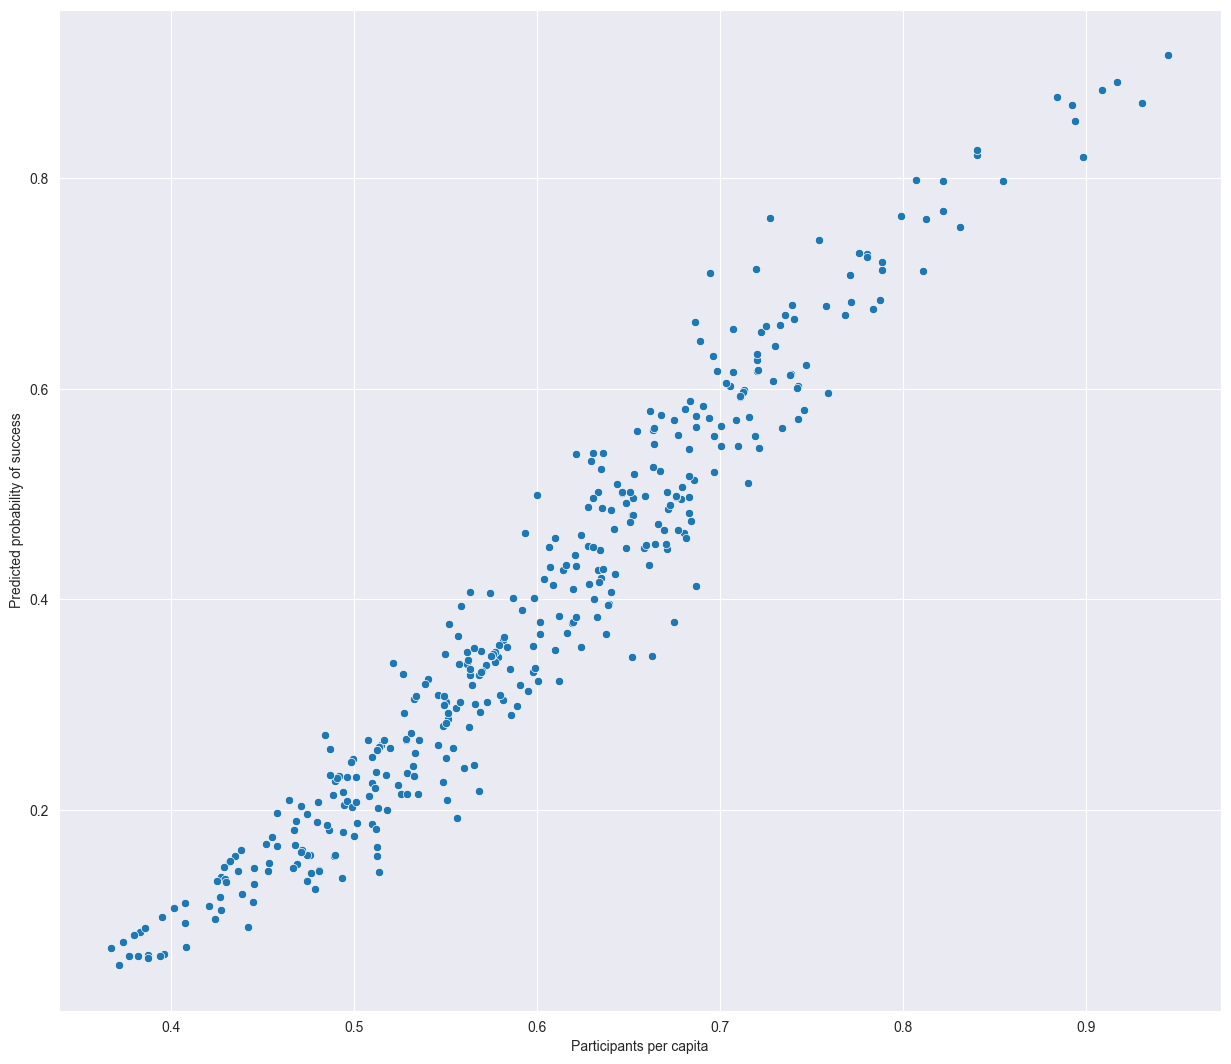

In [19]:
# Set the figure size for the scatter plot
plt.figure(figsize=(15, 13))

# Create a scatter plot for the predicted probability of success against participants per capita
sns.scatterplot(x='PARTICIPANTS_PER_CAPITA', y='PREDICTED_SUCCESS', data=RegData)

# Label the x-axis
plt.xlabel('Participants per capita')

# Label the y-axis
plt.ylabel('Predicted probability of success')

# Show grid lines on the plot
plt.grid(True)

# Put the grid lines behind the plot elements
plt.gca().set_axisbelow(True)

# Display the plot
plt.show()

***Results*** : Examining the outcome, it becomes evident that the likelihood of success rises with an increase in participants per capita. The scatterplot, although exhibiting sparsity, follows a linear pattern. This sparsity is attributed to the unpredictable nature of the population variable, which appears to exert a detrimental impact on the probability of success.

Now to create the second diagram with only the membership per capita and the predicted probability of success, we will follow the same steps as above but this time we will remove the logged population variable from the logistic regression model:

In [20]:
logit_model2 = logit('SUCCESS ~ PARTICIPANTS_PER_CAPITA',data=RegData).fit()
logit_model2.summary2()

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Method:             MLE       
Dependent Variable:   SUCCESS            Pseudo R-squared:   0.123     
Date:                 2023-12-04 14:31   AIC:                449.0222  
No. Observations:     380                BIC:                456.9026  
Df Model:             1                  Log-Likelihood:     -222.51   
Df Residuals:         378                LL-Null:            -253.58   
Converged:            1.0000             LLR p-value:        3.2041e-15
No. Iterations:       6.0000             Scale:              1.0000    
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -5.3469   0.7095 -7.5362 0.0000 -6.7375 -3.9563
PARTICIPANTS_PER_CAPITA  8.0495   1.1414  7.0524 0.0000  5.8125 10.2866
=======================================================================

"""

### Interpreting the Results

- ***Pseudo R-squared (0.130)***: Pseudo R-squared: 0.123, suggesting a moderate level of explanatory power.

- ***Intercept (-5.3469)***: The estimated log-odds of success when all predictor variables are zero. It is significantly different from zero (p-value < 0.0001).

- ***PARTICIPANTS_PER_CAPITA  (8.0495)***: The coefficient represents the change in the log-odds of success for a one-unit increase in PARTICIPANTS_PER_CAPITA. It has a highly significant positive effect (p-value < 0.0001), suggesting a strong association with success.

- ***LLR (Likelihood Ratio Test) p-value (3.2041e-15)***: Significantly low p-value indicates that the model with predictors is significantly better than a null model without predictors.

- ***AIC (Akaike Information Criterion)***: 449.0222

- ***BIC (Bayesian Information Criterion)***: 456.9026

Both AIC and BIC are relatively low, indicating a good fit. Lower values are preferred.

In comparison to the previous model, the addition of the variable LOGGED_POPULATION in the previous model is no longer present. This simplified model with only PARTICIPANTS_PER_CAPITA appears to have slightly better model fit metrics, as indicated by lower AIC and BIC values. The Pseudo R-squared has decreased slightly, but this is expected when fewer predictors are included.

The analysis indicates that PARTICIPANTS_PER_CAPITA is a stronger predictor of success, and the simplified model provides a clear and significant association with the outcome variable.

Now we are going to plot the scatter plot for the predicted probability of success and the participants per capita. First we need to calculate the predicted probability of success for each campaign:

In [21]:
RegData['PREDICTED_SUCCESS'] = logit_model2.predict(RegData[['PARTICIPANTS_PER_CAPITA']])

And to create the scatter plot:

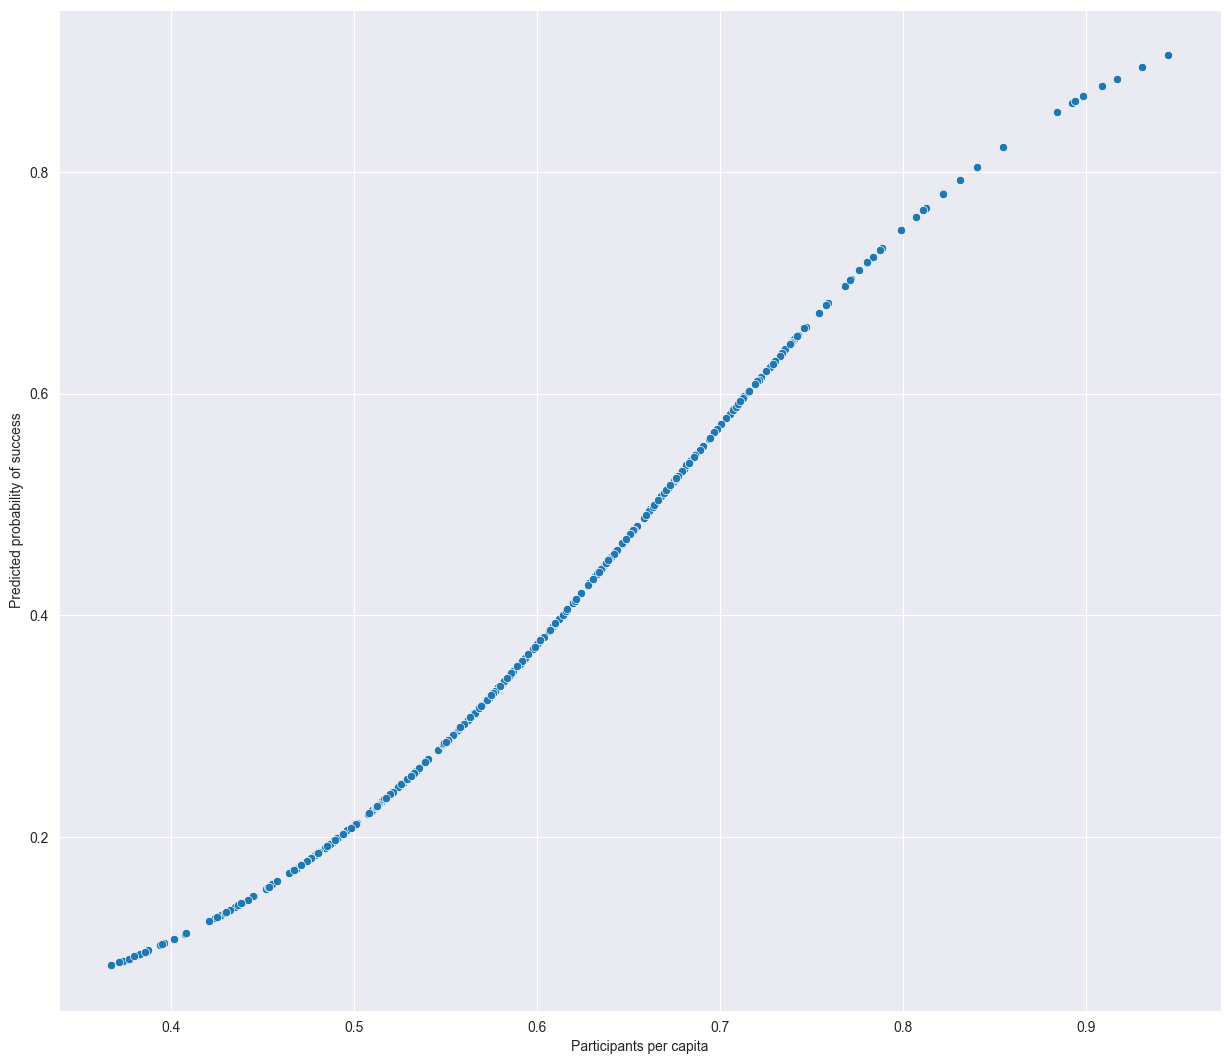

In [22]:
# Set the figure size for the scatter plot
plt.figure(figsize=(15, 13))

# Create a scatter plot for the predicted probability of success and participants per capita
sns.scatterplot(x='PARTICIPANTS_PER_CAPITA', y='PREDICTED_SUCCESS', data=RegData)

# Label the x-axis
plt.xlabel('Participants per capita')

# Label the y-axis
plt.ylabel('Predicted probability of success')

# Show grid lines on the plot
plt.grid(True)

# Put the grid lines behind the plot elements
plt.gca().set_axisbelow(True)

# Display the plot
plt.show()

***Results*** : Here is evident that the plot follows a linear sigmoid pattern, with a slight increase in the likelihood of success with an increase in participants per capita. We can see that it is not sparsed at all and that is because we removed the logged population variable from the logistic regression model and  with that we can confirm that the Participants per capita is a strong predictor of success.

## Task 4: The Level of Participation Tipping Point

A famous output of the research is the 3.5% rule regarding the population participation in a campaign and the probability of success.
Using the data we will create a table like the one given and we will try to examine this rule and see if it is true.

In [23]:
# Filter out rows where 'PARTICIPATION' column has non-null values
tipping_point = navco[navco['PARTICIPATION'].notna()].copy()

# Select relevant columns from the DataFrame
tipping_point = tipping_point[['PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS']]

# Convert 'PERCENTAGEPOPULARPARTICIPATION' to percentage by multiplying by 100
tipping_point['PERCENTAGEPOPULARPARTICIPATION'] = tipping_point['PERCENTAGEPOPULARPARTICIPATION'] * 100

# Create bins for categorizing participation levels
bins = [0, 0.0035, 0.015, 0.06, 0.25, 1.0, 3.5, float('inf')]

# Create labels for the bins
labels = [
    'less than 0.0035%',
    '0.0035% - 0.015%',
    '0.015% - 0.06%',
    '0.06% - 0.25%',
    '0.25% - 1.0%',
    '1.0% - 3.5%',
    'greater than 3.5%'
]

# Add a new column 'Participation Level' based on bins
tipping_point['Participation Level'] = pd.cut(
    tipping_point['PERCENTAGEPOPULARPARTICIPATION'],
    bins=bins,
    labels=labels,
    right=False,  # Include the left bin edge, exclude the right bin edge
    include_lowest=True  # Include the lowest value in the first bin
)

# Group by 'Participation Level' and calculate the summary statistics
summary_stats = tipping_point.groupby('Participation Level', observed=False).agg(
    Observations=('SUCCESS', 'count'),  # Count the number of successful campaigns as observations
    Success_Rate=('SUCCESS', 'mean')  # Calculate Success Rate based on successful campaigns
).sort_values(by='Success_Rate', ascending=False).reset_index()

# Convert Success Rate to percentage and update the 'Success_Rate' column
summary_stats['Success_Rate'] = ((summary_stats['Success_Rate'] * 100).round(2)).astype(str) + '%'

summary_stats

,Participation Level,Observations,Success_Rate
0,greater than 3.5%,18,88.89%
1,1.0% - 3.5%,41,60.98%
2,0.25% - 1.0%,92,45.65%
3,0.06% - 0.25%,95,45.26%
4,0.015% - 0.06%,66,24.24%
5,0.0035% - 0.015%,44,9.09%
6,less than 0.0035%,24,4.17%


In [24]:
# Create a PrettyTable object for displaying the summary statistics
table = PrettyTable()

# Set the field names for the table
table.field_names = ["Participation Level", "Observations", "Success Rate"]

# Iterate over the rows in the summary_stats DataFrame and add them to the PrettyTable
for index, row in summary_stats.iterrows():
    # Add a row to the table with values from the current row in the DataFrame
    table.add_row([row['Participation Level'], row['Observations'], row['Success_Rate']])

# Print the table to display the summary statistics in a formatted manner
print(table)

+---------------------+--------------+--------------+
| Participation Level | Observations | Success Rate |
+---------------------+--------------+--------------+
|  greater than 3.5%  |      18      |    88.89%    |
|     1.0% - 3.5%     |      41      |    60.98%    |
|     0.25% - 1.0%    |      92      |    45.65%    |
|    0.06% - 0.25%    |      95      |    45.26%    |
|    0.015% - 0.06%   |      66      |    24.24%    |
|   0.0035% - 0.015%  |      44      |    9.09%     |
|  less than 0.0035%  |      24      |    4.17%     |
+---------------------+--------------+--------------+


The 3.5% rule, conceptualized by political scientist Erica Chenoweth, originates from her extensive research on civil resistance movements. This empirical guideline emerged through a meticulous examination of historical data encompassing diverse campaigns, spanning both violent and nonviolent approaches.

A pivotal aspect of Chenoweth's analysis focused on gauging the active participation levels within these campaigns, measured as a percentage of the total population. This metric facilitated cross-country and cross-context comparisons, providing valuable insights.

Chenoweth's groundbreaking observation revealed a consistent pattern: campaigns that mobilized approximately 3.5% of the population consistently achieved their goals. This pattern transcended geographical boundaries and political landscapes, showcasing the universality of the principle.

Derived from this empirical insight, the 3.5% rule suggests that when a movement successfully mobilizes around 3.5% of the population in sustained resistance, it invariably approaches a tipping point that significantly increases the likelihood of success. This rule underscores the significance of reaching a critical mass for substantial political or social change.

It's essential to note that the 3.5% rule does not serve as an absolute formula guaranteeing success. Rather, it represents a observed trend in historical data. The success of a movement remains contingent on various factors, encompassing the nature of the governing regime, the strategy employed in resistance, and the broader contextual elements at play.

From the results of the previous question, we can find the percentage of the population that is the tipping point for success in a campaign with 99% probability.

The formula for the logistic regression model is:

$$ P(y) = \frac{1}{1 + e^{-(intercept + coef*x)}} $$

- P(Y) represents the probability of the event (e.g., success),
- X are the predictor variables in this case membership per capita,
- b0 is the intercept,
- b1 is the coefficient for the predictor variable.

This equation can be rearranged to solve for the predictor variable:

$$ x = \frac{log(\frac{P(y)}{1 - P(y)}) - b0}{b1} $$

And now we can calculate the tipping point:


In [25]:
# Extracting the coefficient for the 'PARTICIPANTS_PER_CAPITA' predictor variable from the logistic regression model
coef = logit_model2.params['PARTICIPANTS_PER_CAPITA']

# Extracting the intercept from the logistic regression model
intercept = logit_model2.params['Intercept']

# Setting a threshold for the desired success probability
success_probability_threshold = 0.99

# Calculating the log-odds corresponding to the chosen success probability threshold
log_odds = np.log(success_probability_threshold / (1 - success_probability_threshold))

# Calculating the tipping point using the logistic regression formula: log(odds) = intercept + coef * x
tipping_point = (log_odds - intercept) / coef

tipping_point

1.235106026445725

Now we to exponentiate the tipping point to get the membership per capita

In [26]:
# Converting the tipping point from log-odds to probability using the inverse logit function
tipping_point = np.exp(tipping_point)

# Printing the calculated tipping point
tipping_point

3.4387430990858654

Upon examination, it becomes evident that the tipping point we have reached is below the 3.5% (specifically 3.44%) threshold suggested by Chenoweth. This discrepancy could be attributed to the limited explanatory power of the employed model, with a pseudo R-squared value of 0.123. Additionally, relying on just one variable to forecast the success rate may not be sufficient for obtaining a more precise estimate of the tipping point.

Also we can see that the tipping point before using the .exp() function was 1.23 which is impossible because

$$ participation < population $$ (the chance of having a participation equal to the population are really low)
the ln function is monotonic increasing so we have

$$ ln(participation) < ln(population) $$

and the ln function is possitive for all values greater than 1 (also its impossible to have a population below 1) so we have

$$ \frac{ln(participation)}{ln(population)} < 1 $$

so the result is 

$$ members per capita < 1 $$


But we get a tipping point of 1.23 this can be attributed to the fact that our pseudo R-squared value is 0.123 which is not that high.


## Task 5: Nonviolent Resistance and Target Regime Type

For this task we need to examine whether nonviolent resistance remains significant even if we control for the regime type. To do that we will run a logistic regression of success on the nonviolence indicator controlling for the Polity V score of campaign target, the log of participation, and the location’s logged population the year the campaign ends. 

For our analysis we will use the polity2 score as it provides a revised version of the polity score that is more consistent with the polity5 score. The polity2 score is a summary measure of a country's democratic and free nature. It ranges from -10 (hereditary monarchy) to +10 (consolidated democracy.

In [27]:
# Create a subset of the 'polity5' DataFrame containing relevant columns: 'country', 'polity2', 'year'
logic_polity5_data = polity5[['country','polity2', 'year']]

# Create a copy of the subset DataFrame
logic_polity5_data = logic_polity5_data.copy()

# Convert the 'year' column to integer type
logic_polity5_data['year'] = logic_polity5_data['year'].astype(int)

# Keep the data that is after the year 1945
logic_polity5_data = logic_polity5_data[logic_polity5_data['year'] >= 1945]

# Create a copy of the 'navco' DataFrame
navco_copy = navco

# Merge the two DataFrames ('navco_copy' and 'logic_polity5_data') based on location and year
merged_p5_navco = pd.merge(navco_copy, logic_polity5_data, left_on=['LOCATION', 'EYEAR'], right_on=['country', 'year'], how='left')

# Drop rows with NaN values in the 'polity2' and 'year' columns
merged_p5_navco = merged_p5_navco.dropna(subset=['polity2', 'year'])

# Drop unnecessary columns 'year' and 'country'
merged_p5_navco = merged_p5_navco.drop(['year', 'country'], axis=1)

# Keep only the columns: 'PARTICIPATION', 'SUCCESS', 'polity2', 'PERCENTAGEPOPULARPARTICIPATION', 'NONVIOL'
merged_p5_navco = merged_p5_navco[['PARTICIPATION', 'SUCCESS', 'polity2', 'PERCENTAGEPOPULARPARTICIPATION','NONVIOL']]

# Calculate the population from the 'PERCENTAGEPOPULARPARTICIPATION' column (participants/population)
merged_p5_navco['PERCENTAGEPOPULARPARTICIPATION'] = merged_p5_navco['PERCENTAGEPOPULARPARTICIPATION'].dropna()
merged_p5_navco['POPULATION'] = merged_p5_navco['PARTICIPATION'] / merged_p5_navco['PERCENTAGEPOPULARPARTICIPATION']

# Calculate the logarithm of population
merged_p5_navco['LOGGED_POPULATION'] = np.log(merged_p5_navco['POPULATION'])

# Calculate the logarithm of participants
merged_p5_navco['LOGGED_PARTICIPANTS'] = np.log(merged_p5_navco['PARTICIPATION'])

# Drop rows with any NaN values
merged_p5_navco = merged_p5_navco.dropna()

# Display the resulting DataFrame
merged_p5_navco

,PARTICIPATION,SUCCESS,polity2,PERCENTAGEPOPULARPARTICIPATION,NONVIOL,POPULATION,LOGGED_POPULATION,LOGGED_PARTICIPANTS
1,10000.0,1.0,-8.0,0.000685,0.0,1.460000e+07,16.496532,9.210340
2,20000.0,1.0,-7.0,0.000893,0.0,2.240000e+07,16.924572,9.903488
3,60000.0,0.0,-1.0,0.001625,0.0,3.692109e+07,17.424293,11.002100
4,300000.0,1.0,3.0,0.091068,1.0,3.294227e+06,15.007682,12.611538
5,39000.0,1.0,-8.0,0.003545,0.0,1.100000e+07,16.213406,10.571317
...,...,...,...,...,...,...,...,...
379,10000.0,0.0,-6.0,0.000943,1.0,1.060000e+07,16.176365,9.210340
380,12500.0,1.0,-5.0,0.001190,0.0,1.050000e+07,16.166886,9.433484
385,23000.0,1.0,6.0,0.002791,1.0,8.239732e+06,15.924478,10.043249
386,3000.0,1.0,5.0,0.000277,1.0,1.082412e+07,16.197288,8.006368


Before you move to the logistic regression we need to check for multicollinearity between the predictor variables because it can cause problems with the model. We will do that by calculating the VIF (Variance Inflation Factor) for each predictor variable.

In [28]:
vif_data2 = merged_p5_navco[['NONVIOL', 'polity2', 'LOGGED_PARTICIPANTS', 'LOGGED_POPULATION']]

# Add a constant term to the predictor variable set
vif_data2 = sm.add_constant(vif_data2)

# Calculate VIF for each predictor variable
vif2 = pd.DataFrame()
vif2["Variable"] = vif_data2.columns[1:]  # Exclude the constant term from the variable list

# Initialize the 'VIF' column with NaN values
vif2["VIF"] = [variance_inflation_factor(vif_data2.values, i) for i in range(1, vif_data2.shape[1])]

vif2

,Variable,VIF
0,NONVIOL,1.335934
1,polity2,1.032011
2,LOGGED_PARTICIPANTS,1.345577
3,LOGGED_POPULATION,1.067962


We can see that the VIF for all variables is below the threshold, that is  5 which means that there is no multicollinearity between the predictor variables.

Now we will procceed with the logistic regression that has as an independent variable the success indicator and as independent variables the nonviolence indicator the polity2 score, the log of participation, and the location’s logged population the year the campaign ends.

In [29]:
#logistic regression
logit_model = logit('SUCCESS ~ NONVIOL + polity2 + LOGGED_PARTICIPANTS + LOGGED_POPULATION',data=merged_p5_navco).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.536938
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Method:           MLE       
Dependent Variable:   SUCCESS          Pseudo R-squared: 0.203     
Date:                 2023-12-04 14:31 AIC:              328.9411  
No. Observations:     297              BIC:              347.4098  
Df Model:             4                Log-Likelihood:   -159.47   
Df Residuals:         292              LL-Null:          -199.97   
Converged:            1.0000           LLR p-value:      1.0749e-16
No. Iterations:       6.0000           Scale:            1.0000    
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept            1.8727   1.4980  1.2501 0.2113 -1.0634  4.8087
NONVIOL              0.8662   0.2951  2.9355 0.0033  0.2879  1.4445
polity2              0.0522   0.0254  2.0573 0.0397  0.0025  0.1020
LOGGED_PARTICIPANTS  0.4367   0.0901  4.8493 0.0000  0.2602  0.6132
LOGGED_POPULATION   -0.4270   0.0988 -4.3212 0.0000 -0.6207 -0.2333
===================================================================

"""

***Results***

- ***Pseudo R-squared (0.203)***: it is within the range of 0.2 and 0.4 which means that the model has a good level of explanatory power.

- ***Intercept (1.8727)***: The estimated log-odds of success when all predictor variables are zero. It is not significantly different from zero (p-value = 0.2113).

- ***NONVIOL (0.8662)***: A positive coefficient indicates that an increase in the NONVIOL variable is associated with an increase in the log-odds of success. It is significantly different from zero (p-value = 0.0033).

- ***polity2 (0.0522)***: A positive coefficient implies that an increase in the polity2 variable is associated with an increase in the log-odds of success. It is marginally significant (p-value = 0.0397).

- ***LOGGED_PARTICIPANTS (0.4367)***: A positive coefficient indicates that an increase in the LOGGED_PARTICIPANTS variable is associated with an increase in the log-odds of success. It is significantly different from zero (p-value < 0.0001).

- ***LOGGED_POPULATION (-0.4270)***: A negative coefficient implies that an increase in the LOGGED_POPULATION variable is associated with a decrease in the log-odds of success. It is significantly different from zero (p-value = 0.0001).

- ***AIC (328.9411) and BIC (347.4098)***: Both AIC and BIC are relatively low, indicating good model fit. The lower the values, the better the balance between goodness of fit and model complexity.


In summary, the logistic regression model with multiple predictors provides an understanding of the factors influencing the likelihood of success. Variables such as NONVIOL, LOGGED_PARTICIPANTS, and LOGGED_POPULATION emerge as statistically significant predictors. The Pseudo R-squared suggests that the model captures a meaningful proportion of the variability in success, but further exploration and validation may be warranted to enhance predictive accuracy. The overall model fit, as indicated by AIC and BIC.

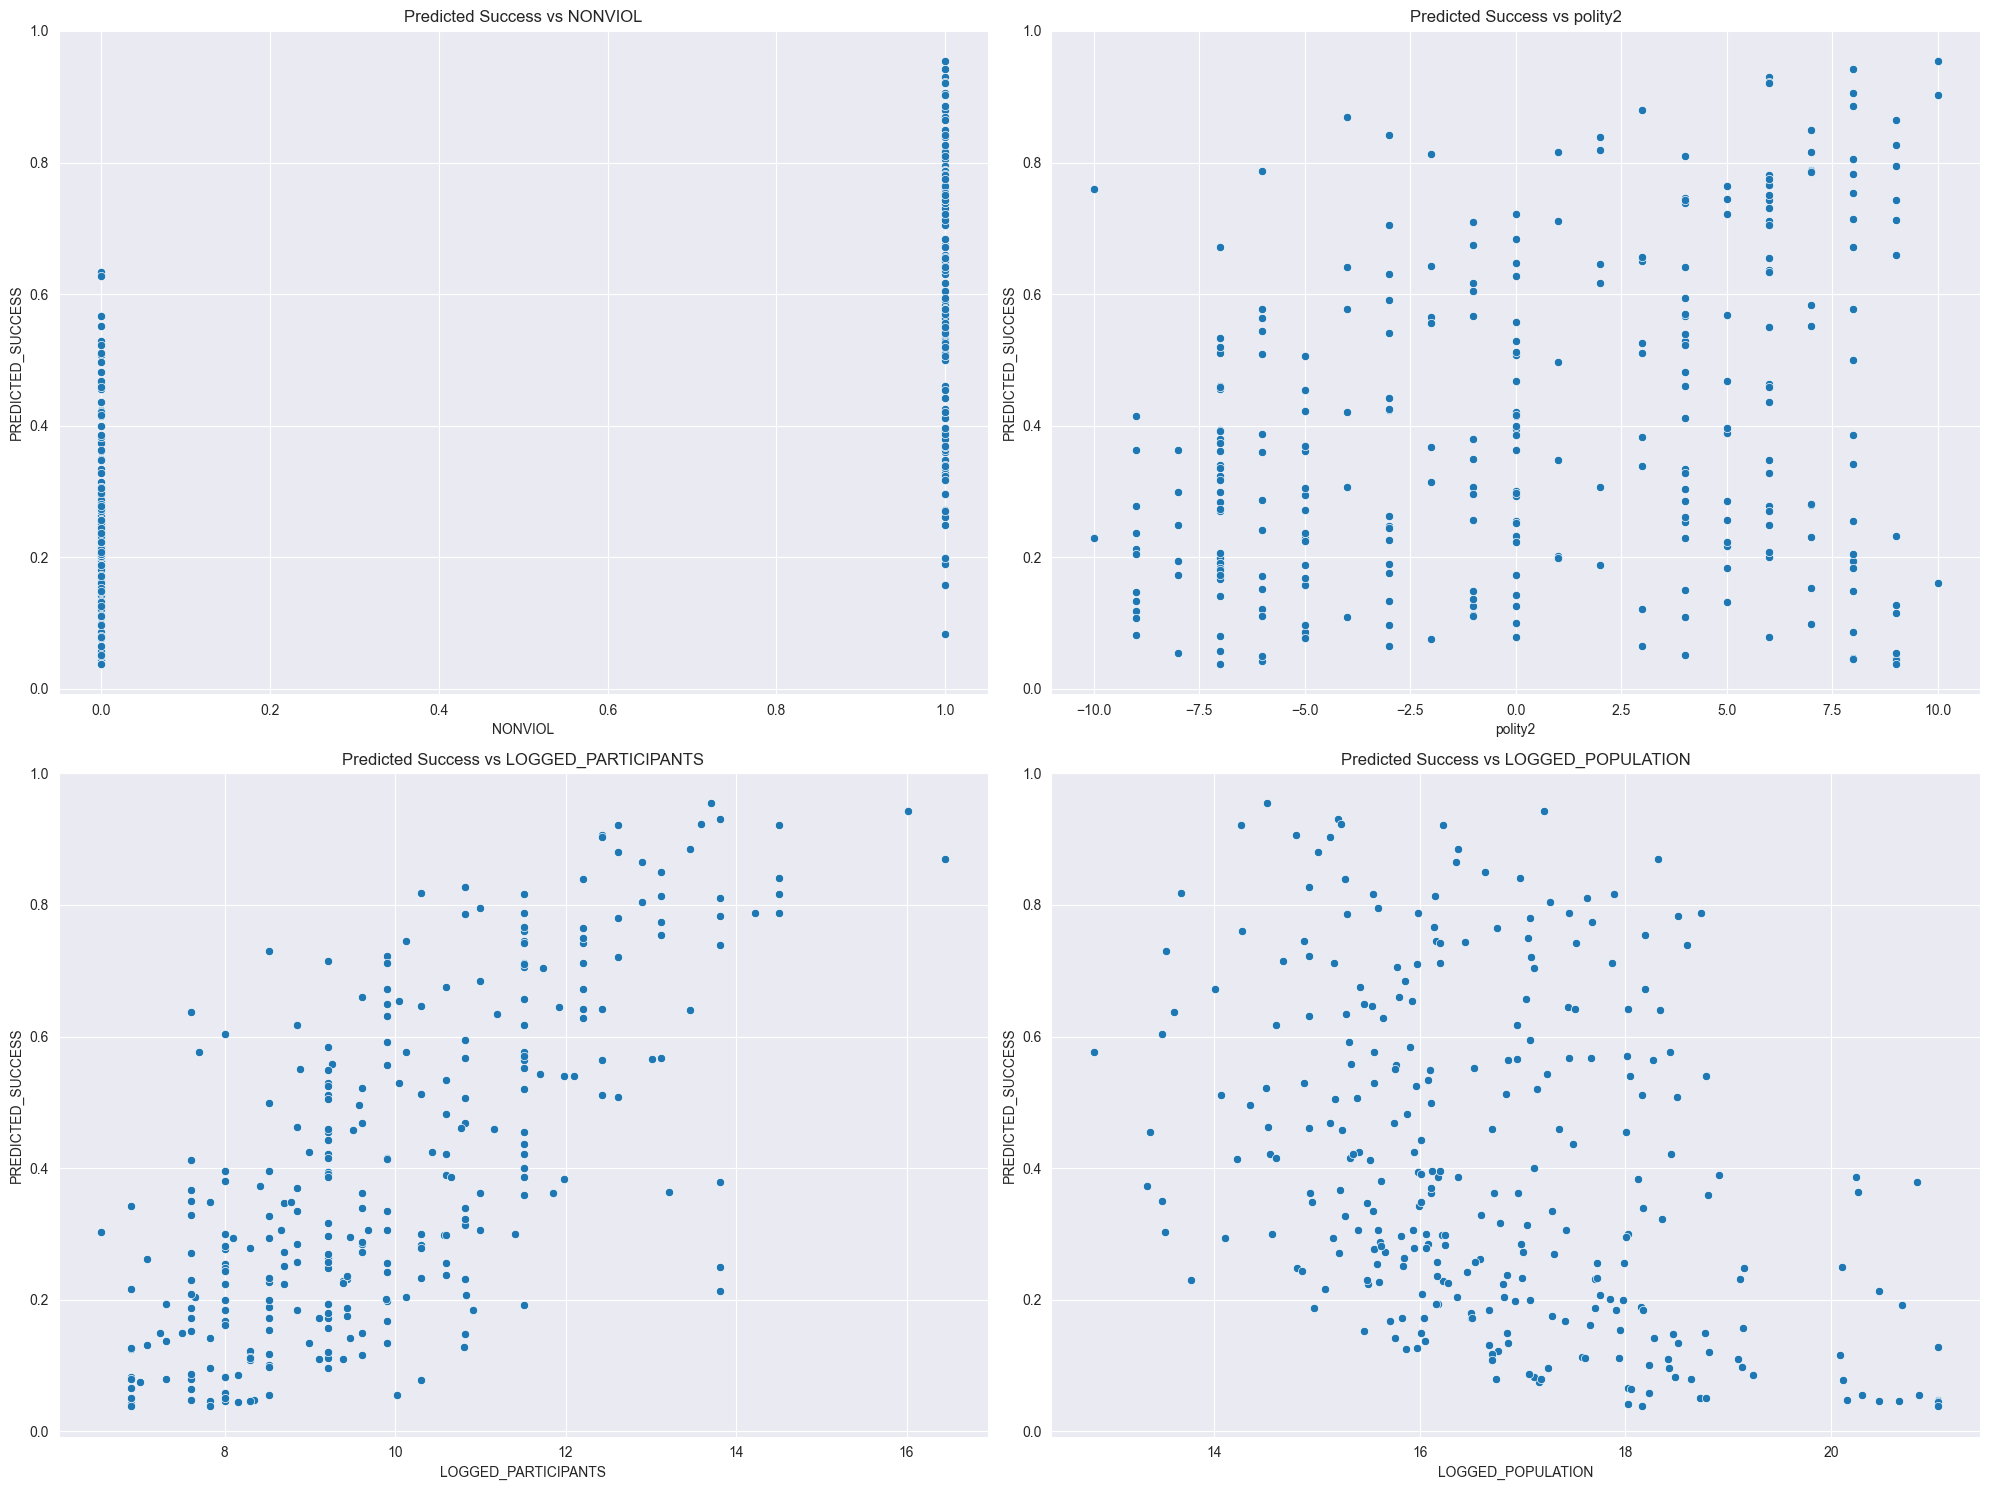

In [30]:
#Predict the probability of success

merged_p5_navco['PREDICTED_SUCCESS'] = logit_model.predict(merged_p5_navco[['NONVIOL', 'polity2', 'LOGGED_PARTICIPANTS', 'LOGGED_POPULATION']])

plt.figure(figsize=(20, 15))

#Subplot for NONVIOL
plt.subplot(2, 2, 1)
sns.scatterplot(x='NONVIOL', y='PREDICTED_SUCCESS', data=merged_p5_navco)
plt.title('Predicted Success vs NONVIOL')
plt.grid(True)

#Subplot for polity2
plt.subplot(2, 2, 2)
sns.scatterplot(x='polity2', y='PREDICTED_SUCCESS', data=merged_p5_navco)
plt.title('Predicted Success vs polity2')
plt.grid(True)

#Subplot for LOGGED_PARTICIPANTS
plt.subplot(2, 2, 3)
sns.scatterplot(x='LOGGED_PARTICIPANTS', y='PREDICTED_SUCCESS', data=merged_p5_navco)
plt.title('Predicted Success vs LOGGED_PARTICIPANTS')
plt.grid(True)

#Subplot for LOGGED_POPULATION
plt.subplot(2, 2, 4)
sns.scatterplot(x='LOGGED_POPULATION', y='PREDICTED_SUCCESS', data=merged_p5_navco)
plt.title('Predicted Success vs LOGGED_POPULATION')
plt.grid(True)

#Display the plot
plt.tight_layout()
plt.show()

#### DIAGRAM ANALYSIS


***Task 5 Assessment***

From the first scatter plot we can see that the predicted probability of success is higher when the campaign is nonviolent. This is expected because the coefficient for the NONVIOL variable is positive and statistically significant. This also means that nonviolent campaigns are more likely to succeed than violent campaigns. So we can conclude that nonviolent resistance remains significant even if we control for the regime type.


***Further Analysis***


Examining the scatterplot depicting polity2 scores against the success rate we can see that as the polity2 score increases, so does the success rate which is expected because the coefficient for the polity2 variable is positive. This means that the higher the polity2 score, the higher the odds of success that translates to, the more democratic the target regime, the higher the odds of success. 

The third scatterplot shows that the predicted probability of success increases with the log of participation. The coefficient for the LOGGED_PARTICIPANTS variable is positive and statistically significant, indicating that higher participation is associated with higher odds of success.

Finally the scatterplot for the LOGGED_POPULATION variable shows that the predicted probability of success decreases with the log of population. The coefficient for the LOGGED_POPULATION variable is negative and statistically significant, indicating that higher population is associated with lower odds of success.